In [ ]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

# Transformer model for hysteresis prediction

This notebook showcases a use of the Transformer architecture for time series prediction, specifically to construct a mapping from measured current (I) to measured field (B) in the CERN Super Proton Synchrotron (SPS) main dipoles. This is not a conventional time series forecasting use-case, as the time-axis is implicitly embedded in the data points, which are sampled at 1kHz (1 ms constant resolution). 

We perform "forecasting" as a multivariate time series prediction, with a past context consisting the past I and B, and future context with future I, to predict the corresponding future B.

The dataset used is measured data from the SPS main dipoles during from an Individual System Test (IST) during the Year End Technical Shutdown (YETS) of the CERN accelerator complex 2023-2024, collected using the online B-Train measurement system.

The notebook only uses standard libraries `pandas`, `numpy`, `matplotlib`, `torch`, `scikit-learn`, for simplicity, as well as `tensorboard` for visialization during training. Additionally, we use (PyTorch) Lightning (`lightning`) to abstract away the training loop and the code more concise.

First, we install the necessary packages

In [ ]:
!pip install lightning torch tensorboard pandas numpy matplotlib scikit-learn pyarrow rich

The training and validation datasets are available on CERNBox, as well as a calibration function we have to use later, and can be downloaded using the following links:

In [ ]:
!wget https://cernbox.cern.ch/remote.php/dav/public-files/9Gpqo4qLCJPJAQB/phys+lhcfill+phys_md1_short_wo_precycle.parquet
!wget https://cernbox.cern.ch/remote.php/dav/public-files/8i3wXvpmzB66QR5/phys+lhcfill+phys_md1_very_short_wo_precycle.parquet

!wget https://cernbox.cern.ch/remote.php/dav/public-files/O6EaJdKBk2Y3BTh/SPS_MB_B2I_CALIBRATION_FN.csv

Then, we import the necessary libraries, and configure `torch` to use high precision for matrix multiplications, if tensor cores are available.

In [ ]:
import torch
import lightning as L
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.preprocessing


torch.set_float32_matmul_precision("high")

plt.rcParams['axes.xmargin'] = 0

%load_ext tensorboard

Then, we load our datasets from disk.

In [108]:
TRAIN_DF_PTH = "phys+lhcfill+phys_md1_short_wo_precycle.parquet"
VAL_DF_PTH = "phys+lhcfill+phys_md1_very_short_wo_precycle.parquet"

train_df = pd.read_parquet(TRAIN_DF_PTH)
val_df = pd.read_parquet(VAL_DF_PTH)

The datasets contain the following columns, with the `time_ms` column given as a timestamp in milliseconds, and the `B_meas_T` and `I_meas_A` columns containing the measured magnetic field and current, respectively.

In [109]:
train_df.head(5)

,I_meas_A,B_meas_T,time_ms,USER,CYCLE
cycle_time,,,,,
2023-11-02 10:45:57.735000+01:00,155.616821,0.060329,1.698918e+12,SFTPRO1,SFT_PRO_MTE_L4780_2023_V1
2023-11-02 10:45:57.736000+01:00,155.602783,0.060332,1.698918e+12,SFTPRO1,SFT_PRO_MTE_L4780_2023_V1
2023-11-02 10:45:57.737000+01:00,155.606659,0.060326,1.698918e+12,SFTPRO1,SFT_PRO_MTE_L4780_2023_V1
2023-11-02 10:45:57.738000+01:00,155.588440,0.060325,1.698918e+12,SFTPRO1,SFT_PRO_MTE_L4780_2023_V1
2023-11-02 10:45:57.739000+01:00,155.586197,0.060329,1.698918e+12,SFTPRO1,SFT_PRO_MTE_L4780_2023_V1


In [110]:
len(train_df), len(val_df)

(172800, 82800)

We want to remove the part of the target that is deterministically mapped to the input current, which we do by subtracting the target B field with a discrete /piecewise function of the input current.

In [111]:
CALBIRATION_FN_PTH = "./SPS_MB_B2I_CALIBRATION_FN.csv"
calibration_fn = np.loadtxt(CALBIRATION_FN_PTH, delimiter=",", skiprows=1)

def calibration_fn_interp(current: np.ndarray) -> np.ndarray:
    return np.interp(current, calibration_fn[:, 0], calibration_fn[:, 1])

We add the residual field to the datasets, which is the difference between the measured field the non-time dependent part of the field, i.e. the field that is deterministically mapped to the input current.

In [112]:
train_df["B_meas_T_res"] = train_df["B_meas_T"] - calibration_fn_interp(train_df["I_meas_A"].values)
val_df["B_meas_T_res"] = val_df["B_meas_T"] - calibration_fn_interp(val_df["I_meas_A"].values)

Let's plot the training and validation datasets as time series to see what they look like, here time vs current and field.

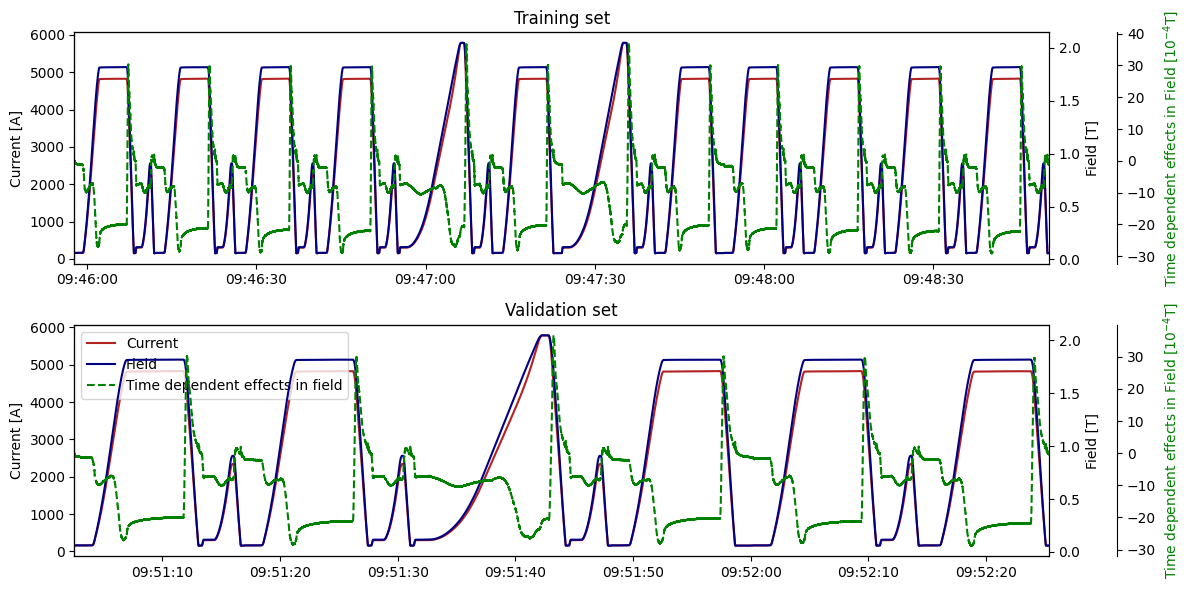

In [113]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# plot training set
plots = []
plots += ax1.plot(train_df["time_ms"].astype("datetime64[ms]"), train_df["I_meas_A"], c="firebrick")
ax11 = ax1.twinx()
ax111 = ax1.twinx()
plots += ax11.plot(train_df["time_ms"].astype("datetime64[ms]"), train_df["B_meas_T"], c="navy")
plots += ax111.plot(train_df["time_ms"].astype("datetime64[ms]"), train_df["B_meas_T_res"] * 1e4, c="green", linestyle="--")
ax1.set_title("Training set")

ax1.set_ylabel("Current [A]")
ax11.set_ylabel("Field [T]")
ax111.set_ylabel("Time dependent effects in Field [$10^{-4}$T]")
ax111.spines["right"].set_position(("axes", 1.07))
ax111.yaxis.label.set_color('green')

# plot validation set
ax2.plot(val_df["time_ms"].astype("datetime64[ms]"), val_df["I_meas_A"], c="firebrick", label="Current")
ax22 = ax2.twinx()
ax222 = ax2.twinx()
ax22.plot(val_df["time_ms"].astype("datetime64[ms]"), val_df["B_meas_T"], c="navy", label="navy")
ax222.plot(val_df["time_ms"].astype("datetime64[ms]"), val_df["B_meas_T_res"] * 1e4, c="green", linestyle="--")

ax2.set_ylabel("Current [A]")
ax22.set_ylabel("Field [T]")
ax222.set_ylabel("Time dependent effects in Field [$10^{-4}$T]")
ax222.spines["right"].set_position(("axes", 1.07))
ax222.yaxis.label.set_color('green')
ax2.legend(plots, ["Current", "Field", "Time dependent effects in field"], loc='upper left')

ax2.set_title("Validation set")

fig.tight_layout()

Now let's define some constants to use for data processing. Since the datasets are quite long, we downsample them by a factor 50 from 1kHz to 20 Hz.
Then, we decide to use a context sequence length of 240 (corresponding to 12 seconds, since the fixed target cycle length is 10.8s), and a prediction horizon of 1.2s, as this corresponds to the basic period in the CERN accelerator complex.

In [114]:
DOWNSAMPLE = 50  # 1kHz to 20Hz
CTXT_SEQ_LEN = 240 # 12s
TARGET_SEQ_LEN = 24 # 1.2s

Neural networks tend to perform better with normalized inputs and outputs. So we initialize 2 standard scalers from sckikit-learn that transform our data into zero-mean and unit variance. We use different scalers for the current and target, since they correspond to different time series.

In [115]:
current_scaler = sklearn.preprocessing.StandardScaler()
field_scaler = sklearn.preprocessing.StandardScaler()

Then fit the scalers to only the training dataset

In [116]:
# scalers want 2D inputs
current_scaler.fit(train_df[["I_meas_A"]].values)
field_scaler.fit(train_df[["B_meas_T_res"]].values)

StandardScaler()

We now use a naive downsampling method by just taking every `DOWNSAMPLE` value. In principle we could take an average value over a window, but we keep this for simplicity.

In [117]:
train_df_downsampled = train_df.iloc[::DOWNSAMPLE]
val_df_downsampled = val_df.iloc[::DOWNSAMPLE]

For the training dataset, we use the "sliding window" technique to create samples of with (past) context `CTXT_SEQ_LEN` and future / prediction horizon `TARGET_SEQ_LEN`, which means windows of total length `CTXT_SEQ_LEN + TARGET_SEQ_LEN`, with a stride of 1.

For the Transformer encoder input, we need a tensor of shape `(CTXT_SEQ_LEN, 2)`, where the first column is a window of the past current, and the second column the corresponding window of the past field. 
For the Transformer decoder input, we need a tensor of shape `(TARGET_SEQ_LEN, 2)`, where the first column is a window of the future current, and the second column is filled with zeros, since it is the covariate that we want to predict. We put zeros in this column to keep the decoder input to have the same amount of columns as the encoder input, to be able to use the same embedding layer.

![Sliding window technique](sliding-window.png)

In [118]:
class TrainDataset(torch.utils.data.Dataset):
    """
    Dataset used for training the transformer model. The dataset is constructed by creating sliding windows of the input and target data.
    """
    def __init__(self, inputs: np.ndarray, targets: np.ndarray, ctxt_seq_len: int, target_seq_len: int):
        self.inputs = torch.from_numpy(inputs).to(torch.float32)
        self.targets = torch.from_numpy(targets).to(torch.float32)
        self.ctxt_seq_len = ctxt_seq_len
        self.target_seq_len = target_seq_len
        
    def __getitem__(self, idx: int) -> dict[str, torch.Tensor]:
        """ make windows of len ctxt_seq_len and tgt_seq_len """
        enc_win = slice(idx, idx + self.ctxt_seq_len)
        dec_win = slice(idx + self.ctxt_seq_len, idx + self.ctxt_seq_len + self.target_seq_len)
        
        encoder_input = torch.cat([self.inputs[enc_win], self.targets[enc_win]], dim=-1)
        decoder_input = torch.cat([self.inputs[dec_win], self.targets[dec_win]], dim=-1)
        target = self.targets[dec_win]
        
        return {
            "encoder_input": encoder_input,
            "decoder_input": decoder_input,
            "target": target,
        }
        
    def __len__(self) -> int:
        return len(self.inputs) - self.ctxt_seq_len - self.target_seq_len

train_dataset = TrainDataset(
    inputs=current_scaler.transform(train_df_downsampled[["I_meas_A"]].to_numpy()),
    targets=field_scaler.transform(train_df_downsampled[["B_meas_T_res"]].to_numpy()),
    ctxt_seq_len=CTXT_SEQ_LEN,
    target_seq_len=TARGET_SEQ_LEN,
)

Then for the validation dataset we use the same method, but without overlapping targets, this means each sliding window is `CTXT_SEQ_LEN` spaced from the previous one, and the last sample is zero-padded so the target horizon remains `TARGET_SEQ_LEN`.

In [119]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        inputs: np.ndarray,
        targets: np.ndarray,
        ctxt_seq_len: int,
        tgt_seq_len: int,
    ):
        """
        Zero-pad the inputs and targets to multiples of the sequence length
        """
        self.num_samples = np.ceil((len(inputs) - ctxt_seq_len) / tgt_seq_len).astype(int)
        self.inputs = torch.from_numpy(np.pad(
            inputs,
            ((0, self.num_samples * tgt_seq_len + ctxt_seq_len - len(inputs)), (0, 0)),
            mode="constant",
            constant_values=0,
        )).to(torch.float32)
        self.targets = torch.from_numpy(np.pad(
            targets,
            ((0, self.num_samples * tgt_seq_len + ctxt_seq_len - len(targets)), (0, 0)),
            mode="constant",
            constant_values=0,
        )).to(torch.float32)
        
        self.ctxt_seq_len = ctxt_seq_len
        self.tgt_seq_len = tgt_seq_len
        
    def __getitem__(self, idx: int) -> dict[str, torch.Tensor]:
        """ make windows of len ctxt_seq_len and tgt_seq_len """
        idx = idx if idx >= 0 else idx + len(self)
        start = idx * self.tgt_seq_len
        end = start + self.ctxt_seq_len + self.tgt_seq_len
        
        return {
            "encoder_input": torch.cat(
                (self.inputs[start : start + self.ctxt_seq_len],
                self.targets[start : start + self.ctxt_seq_len]),
                dim=-1
            ),
            "decoder_input": torch.cat(
                (
                    self.inputs[start + self.ctxt_seq_len : end],
                    torch.zeros((self.tgt_seq_len, 1)),
                ),
            dim=-1
            ),
            "target": self.targets[start + self.ctxt_seq_len : end],
        }
        
    def __len__(self) -> int:
        return self.num_samples
        
        
val_dataset = ValidationDataset(
    current_scaler.transform(val_df_downsampled["I_meas_A"].values[..., None]),
    field_scaler.transform(val_df_downsampled["B_meas_T_res"].values[..., None]),
    ctxt_seq_len=CTXT_SEQ_LEN,
    tgt_seq_len=TARGET_SEQ_LEN,
)

Each sample in the datasets have 3 keys, the `encoder_input` and `decoder_output` are the inputs to the transformer (source and target, respectively), and the target the ground truth (scaled), for loss calculation.

In [120]:
sample = train_dataset[0]
sample.keys()

dict_keys(['encoder_input', 'decoder_input', 'target'])

The shapes of `encoder_input` and `decoder_input` corresponds to the length of the context and target window, respectively on the first dimension, where the second dimension corresponds to the number of features, i.e. current and field.

In [121]:
sample["encoder_input"].shape, sample["decoder_input"].shape

(torch.Size([240, 2]), torch.Size([24, 2]))

The `target` has as expected shape `(TARGET_SEQ_LEN, 1)`

In [122]:
sample["target"].shape

torch.Size([24, 1])

We create the corresponding dataloaders for training and validation loops. For the validation dataloader we keep a batch size of 1 for simplicity.

In [123]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

The positional encoding is required to tell the transformer the order of the elements. It is simply a reimplementation of the positional encoding presented in "Attention is All You Need" ([arXiv:1706.03762](https://arxiv.org/abs/1706.03762)).

In [124]:
class SimplePositionalEncoding(torch.nn.Module):
    def __init__(
        self, d_model: int, dropout: float = 0.1, max_len: int = 5000
    ):
        super().__init__()

        self.dropout = torch.nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1).to(torch.float32)

        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Creates a basic positional encoding"""
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

We now go through each step of a transformer pipeline with the following steps:
1. Embedding: transform the feature space to the dimension of the transformer
2. Positional encoding: add positional features to the embeddings
3. Feed source and target (encoder and decoder input) to the transformer and get the output
4. Project the transformer outputs from its model dimension to 1, for our sequence point prediction. 

In [125]:
D_MODEL = 64  # transformer dimension

In [126]:
sample = next(iter(train_dataloader))
sample["encoder_input"].shape, sample["decoder_input"].shape

(torch.Size([32, 240, 2]), torch.Size([32, 24, 2]))

We construct an embedding layer, which in our case is simply a linear layer. We could also use an LSTM with output size `D_MODEL`.
The embedding layer transforms our batch from `[batch_size, seq_len, n_feat]` to `[batch_size, seq_len, d_model]`

In [127]:
# we have 2 input features: current and field
embedding = torch.nn.Linear(in_features=2, out_features=D_MODEL)

src_embed = embedding(sample["encoder_input"])
tgt_embed = embedding(sample["decoder_input"])

src_embed.shape, tgt_embed.shape

(torch.Size([32, 240, 64]), torch.Size([32, 24, 64]))

We procceed to add our positional encodings to source and target embeddings, the dimensions will stay unchanged, as the positional encodings are added point-wise to the inputs. The only thing the positional encoding needs is the dimension of our transformer.

In [128]:
pos_enc = SimplePositionalEncoding(d_model=D_MODEL)

src = pos_enc(src_embed)
tgt = pos_enc(tgt_embed)

src.shape, tgt.shape

(torch.Size([32, 240, 64]), torch.Size([32, 24, 64]))

Then we build our Transformer, which is a pre-defined module in `torch.nn`, the module actually containing the powerful multihead self-attention and feed-forward layers that relate our features to each other. Here we need to tell the transformer how many encoder and decoder layers we want, number of heads per layer, the dimension of the feed-forward layers, dropout, and activation function. 

The Transformer Encoder and Decoder each output the same dimensions as it takes input, which means that our prediction output dimensions will be the same as the decoder input; `[batch_size, horizon_len, d_model]`

In [129]:
transformer = torch.nn.Transformer(
    num_encoder_layers=2,
    num_decoder_layers=2,
    d_model=D_MODEL,
    nhead=4,
    dim_feedforward=512,
    activation="relu",
    dropout=0.1,
    batch_first=True,
)

decoded = transformer(src=src, tgt=tgt)
decoded.shape

torch.Size([32, 24, 64])

Finally finally we can project the transformer output to a point prediction for our time series using another linear layer. Alternatively an MLP can be used, or Gated Residual Networks, ...


In [130]:
fc = torch.nn.Linear(
    in_features=D_MODEL,
    out_features=1,
)

prediction = fc(decoded)
prediction.shape

torch.Size([32, 24, 1])

And there we go! We have predicted one batch of 64 sequences with 24 points horizon each, with a context of 240 points!
Just for good measure we can calculate the MSE loss as well:

In [131]:
torch.nn.functional.mse_loss(prediction, sample["target"])

tensor(0.9988, grad_fn=<MseLossBackward0>)

Now that we have figured out how the transformer works, we bundle up all of our components in a Lighting module, where we define the steps for loss calculation at training and validation time, and which optimizer to use, then we can use the `lightning.Trainer` to `fit` our model to our training and validation dataloaders.
Since we are making point predictions with our transformer, we will use a simple MSE loss. We could also use MAE loss.

In [132]:
class TransformerModule(L.LightningModule):
    def __init__(self,
        n_feat: int,
        d_model: int = 128,
        n_heads: int = 4,
        n_encoder_layers: int = 8,
        n_decoder_layers: int = 8,
        d_fc: int = 1024,
        activation: str = "relu",
        dropout: float = 0.1,
    ):
        super().__init__()
        self.save_hyperparameters()
        
        self.embedding = torch.nn.Linear(
            in_features=n_feat,
            out_features=d_model,
        )
        
        self.pos_enc = SimplePositionalEncoding(
            d_model=d_model, dropout=dropout,
        )
        
        self.model = torch.nn.Transformer(
            d_model=d_model,
            nhead=n_heads,
            num_encoder_layers=n_encoder_layers,
            num_decoder_layers=n_decoder_layers,
            dim_feedforward=d_fc,
            activation=activation,
            dropout=dropout,
            batch_first=True,
        )
        
        self.fc = torch.nn.Linear(
            in_features=d_model,
            out_features=1,
        )
        
        self.criterion = torch.nn.MSELoss()
        
    def forward(
        self,
        encoder_input: torch.Tensor,
        decoder_input: torch.Tensor,
    ) -> torch.Tensor:
        src_emb = self.embedding(encoder_input)
        src = self.pos_enc(src_emb)
        
        tgt_emb = self.embedding(decoder_input)
        tgt = self.pos_enc(tgt_emb)
        
        decoded = self.model(src=src, tgt=tgt)
        
        return self.fc(decoded)
    
    def training_step(
            self,
            batch: dict[str, torch.Tensor],
            batch_idx: int,
            dataloader_idx: int = 0
    ) -> dict[str, torch.Tensor]:
        target = batch["target"]
        
        output = self(batch["encoder_input"], batch["decoder_input"])
        
        loss = self.criterion(output, target)
        self.log("loss/train", loss)
        
        return {"loss": loss}
    
    def validation_step(
            self,
            batch: dict[str, torch.Tensor],
            batch_idx: int,
            dataloader_idx: int = 0
    ) -> dict[str, torch.Tensor]:
        target = batch["target"]
        
        output = self(batch["encoder_input"], batch["decoder_input"])
        
        loss = self.criterion(output, target)
        self.log("loss/validation", loss)
        
        return {"loss": loss}
    
    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=1e-3)
            

model = TransformerModule(
    n_feat=2,
    n_heads=4,
    n_decoder_layers=4,
    n_encoder_layers=4,
    d_model=D_MODEL,
)

Construct callbacks that will used during training

In [133]:
callbacks = [
    L.pytorch.callbacks.ModelCheckpoint(
        monitor="loss/validation",
        filename="transformer-{epoch:02d}-{loss/validation:.2f}",
        save_top_k=3,
        mode="min",
    ),
    L.pytorch.callbacks.EarlyStopping(
        monitor="loss/validation", patience=100, mode="min"
    ),
    L.pytorch.callbacks.rich_model_summary.RichModelSummary(max_depth=2),
]

Create Trainer instance with the defined callbacks and log to TensorBoard at "./lightning_logs"

In [134]:
trainer = L.Trainer(
    max_epochs=200,
    accelerator="auto",
    logger=L.pytorch.loggers.TensorBoardLogger(""),
    gradient_clip_val=1.0,
    callbacks=callbacks,
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    enable_progress_bar=False,
)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Run tensorboard before we start training

In [ ]:
%tensorboard --logdir "lightning_logs"

Train the model

In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

In [25]:
trainer.checkpoint_callback.best_model_path

'lightning_logs/version_0/checkpoints/transformer-epoch=92-loss/validation=0.01.ckpt'

Let's now load back the best model from a checkpoint to do our toy predictions

In [21]:
model = TransformerModule.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
).to("cpu")

We evaluate the model on the validation set, extract the ground truth from our validation dataset, and inverse transform using our standard scalers. Since we zero-padded the last sample in the validation dataset we also have to trim our ground truth and predictions.

In [135]:
# get point predictions from the model using the quantile loss
predictions = torch.cat([model(o["encoder_input"], o["decoder_input"]).cpu().detach() for o in val_dataloader], dim=1).squeeze(-1)

# get the input current and target field from the dataloader that has been processed and normalize
input_current = torch.cat([o["decoder_input"][..., 0].cpu().detach() for o in val_dataloader], dim=-1)
target_field = torch.cat([o["target"][..., 0].cpu().detach() for o in val_dataloader], dim=-1)

In [136]:
# un-transform the data
input_current = current_scaler.inverse_transform(input_current).T
target_field = field_scaler.inverse_transform(target_field).T

predictions = field_scaler.inverse_transform(predictions).T

# truncate predictions and inputs to the length of amount of data predicted (i.e. remove the context)
real_num_points = len(val_df_downsampled) - CTXT_SEQ_LEN
predictions = predictions[:real_num_points].flatten()

input_current = input_current[:real_num_points].flatten()
target_field = target_field[:real_num_points].flatten()

In [137]:
len(val_dataset)

59

Plot the predicted field and the difference between the predicted and ground truth field, as well as the absolute error distribution.

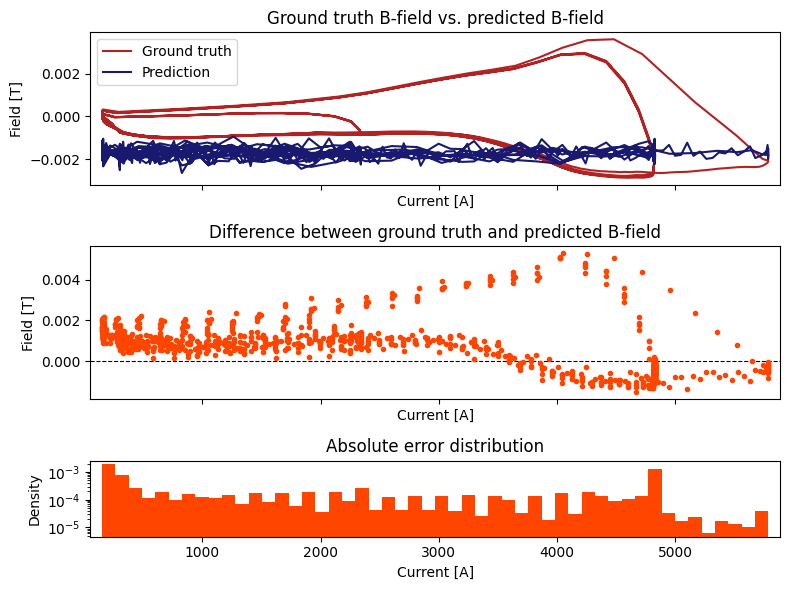

In [140]:
ax1: plt.Axes
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, sharex="all", figsize=(8, 6), height_ratios=[2, 2, 1]
)
ax1.plot(input_current, target_field, label="Ground truth", c="firebrick")
ax1.plot(
    input_current,
    predictions,
    label="Prediction",
    linestyle="-",
    c="midnightblue",
)
ax1.set_xlabel("Current [A]")
ax1.set_ylabel("Field [T]")
ax1.set_title("Ground truth B-field vs. predicted B-field")
ax1.legend()

ax2.axhline(y=0, color="k", linestyle="--", linewidth=0.8)
ax2.plot(
    input_current,
    target_field - predictions,
    marker=".",
    linestyle="none",
    c="orangered",
)
ax2.set_xlabel("Current [A]")
ax2.set_ylabel("Field [T]")
ax2.set_title("Difference between ground truth and predicted B-field")

ax3.hist(
    input_current,
    bins=50,
    weights=np.abs(target_field - predictions),
    density=True,
    log=True,
    color="orangered",
)
ax3.set_xlabel("Current [A]")
ax3.set_ylabel("Density")
ax3.set_title("Absolute error distribution")

ax1.set_xlim(input_current.min() - 100, input_current.max() + 100)

plt.tight_layout()

Plot the predicted field over time

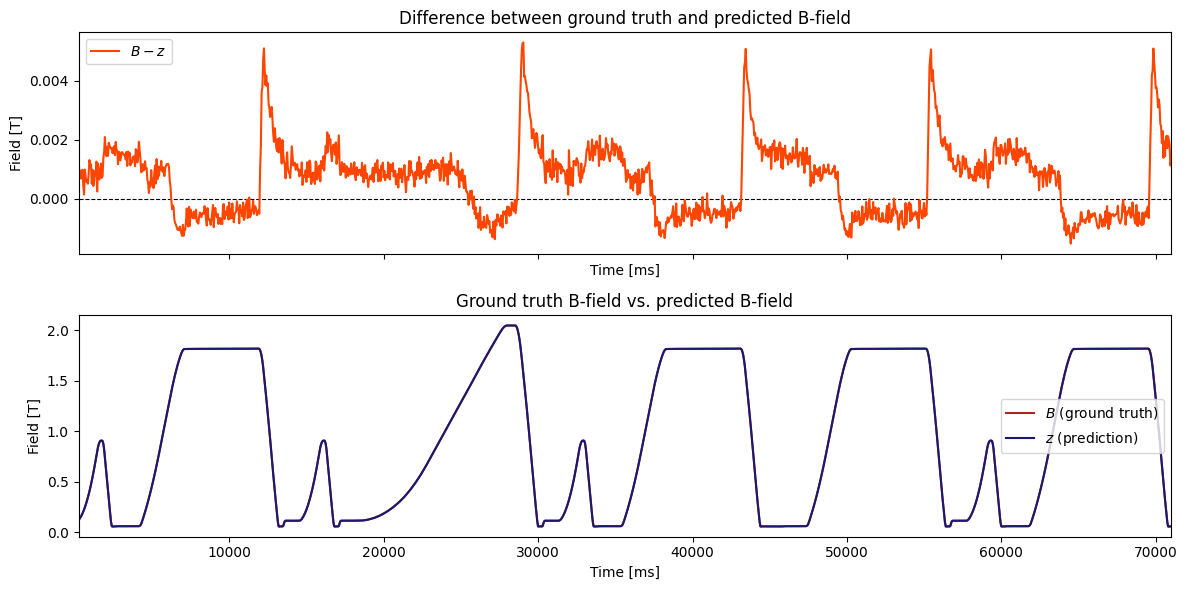

In [141]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex="all", figsize=(12, 6))

x = np.arange(0, len(target_field)) * DOWNSAMPLE + CTXT_SEQ_LEN
ax2.plot(
    x,
    target_field + calibration_fn_interp(input_current),
    label="$B$ (ground truth)",
    c="firebrick",
)
ax2.plot(
    x,
    predictions + calibration_fn_interp(input_current),
    label="$z$ (prediction)",
    linestyle="-",
    c="midnightblue",
)
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Field [T]")
ax2.set_title("Ground truth B-field vs. predicted B-field")
ax2.legend()

ax1.axhline(y=0, color="k", linestyle="--", linewidth=0.8)
ax1.plot(
    x,
    target_field - predictions,
    c="orangered",
    label=r"$B - z$",
)
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Field [T]")
ax1.set_title("Difference between ground truth and predicted B-field")
ax1.legend()

plt.tight_layout()